In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import marginal as mg
import matplotlib.cm as cm

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

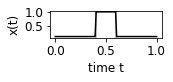

In [149]:
Nsamp = 100
t = np.linspace(0,1,Nsamp)
x = np.zeros_like(t)
x[(t>0.4) & (t<0.6)] = 1
# x[(t>0.6) & (t<0.7)] = 10*(t[(t>0.6) & (t<0.7)]-0.6)
# x[(t>0.8) & (t<0.9)] = 1-10*(t[(t>0.8) & (t<0.9)]-0.8)
x = 0.9*x+0.1
plt.figure(figsize=(2,0.5),frameon=False)
plt.plot(t,x,color='k')
# plt.scatter(t,np.zeros_like(t),color=cm.rainbow(t))
# plt.axis('off')
for i in [0.4,0.6]:
    plt.axvline(i,color='k',alpha=0.3)
plt.xlabel('time t')
plt.ylabel('x(t)')
plt.savefig('toyfig1.pdf')

In [150]:
# add trial-to-trial variability (independent for neurons)
Ntrials = 100
X = np.repeat(x.reshape(-1,1).T,Ntrials,axis=0).flatten()
Y = np.zeros([2,X.size])
np.random.seed(42)

kern_len = 20
t = np.linspace(0,1,kern_len)
k = np.ones([2,kern_len])
h = np.zeros([2,2,kern_len])
h[0,0] = -0.1#(t**2+t**6-2*t**3)*0.01
h[1,1] = -0.1
h[0,1] = +0.4*(1-t)**2#*(t**2+t**6-2*t**3)
h[1,0] = -0.1*t**2
for time in range(kern_len,X.size):
    for i in range(2):
        lam = 0.2*np.exp(k[i]@X[time-kern_len:time]+\
                     np.sum([h[i,j]@Y[j,time-kern_len:time] for j in range(2)]))
        Y[i,time] = np.random.poisson(lam=lam)

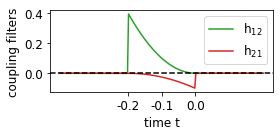

In [151]:
plt.figure(figsize=(4,1.5))
t = np.linspace(-1,2,kern_len*10)
mask = (t>0) & (t<1)
plt.plot(t*0.2,[0.4*(1-tt)**2 if m else 0 for tt,m in zip(t,mask)],c='C2',label=r'h$_{12}$')
plt.plot(t*0.2,[-0.1*tt**2 if m else 0 for tt,m in zip(t,mask)],c='C3',label=r'h$_{21}$')
plt.axhline(0,c='k',linestyle='dashed')
plt.xticks(np.arange(0,0.201,0.1),np.round(np.arange(0,0.201,0.1)-0.2,2))
plt.xlabel('time t')
plt.ylabel('coupling filters')
plt.legend()
plt.savefig('toyfig3.pdf')

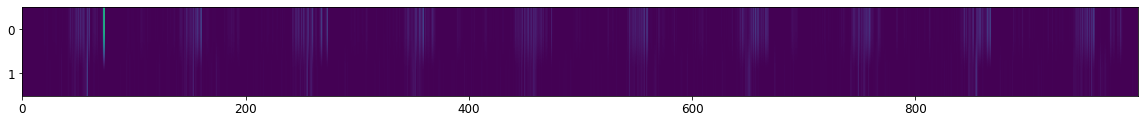

In [122]:
plt.figure(figsize=(20,2))
plt.imshow(Y[:,:10*Nsamp],aspect=40)

202.0


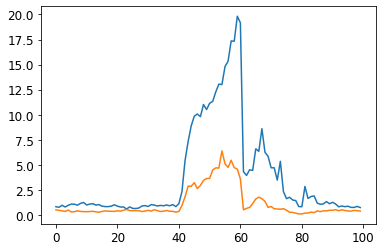

In [123]:
y=Y.reshape([2,Ntrials,Nsamp])
print(y.max())
plt.plot(np.mean(y,axis=1).T)

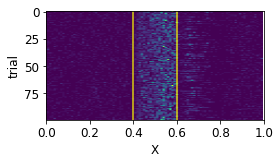

In [124]:
plt.figure(figsize=(6,2))
plt.xlabel('X')
plt.ylabel('trial')
for i in [0.4,0.6]:
    plt.axvline(i*Nsamp,color='yellow',alpha=0.8)
plt.xticks(np.arange(0,101,20),labels=np.round(np.arange(0,1.1,0.2),1))
plt.imshow(np.clip(y[1],0,30),aspect=0.5)
plt.xlim(0,100)
plt.savefig('toyfig2.pdf')

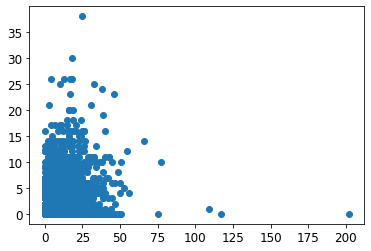

In [125]:
y = y.reshape(2,-1)
plt.scatter(*y)

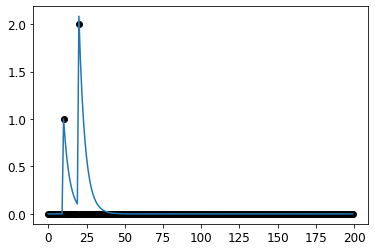

In [130]:
l_points = 0.4*10 # 760 ms to points
size_points = int(l_points*10)
discrete_filter = np.array([np.exp(-i/l_points) for i in range(size_points+1)])

signal = np.zeros(200)
signal[10] = 1
signal[20] = 2
plt.scatter(np.arange(len(signal)),signal,c='k')
plt.plot(np.arange(len(signal)),np.convolve(signal,discrete_filter,mode='full')[:-size_points])

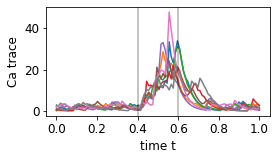

In [156]:
# simulate ca measurements
t = np.linspace(0,1,Nsamp)
tt = np.repeat(t.reshape(-1,1),Ntrials,axis=-1).T.reshape(-1)
y_ca = np.zeros_like(Y).astype("float")
for i in range(2):
    y_ca[i] = np.convolve(Y[i],discrete_filter,mode='full')[:-size_points]
plt.figure(figsize=(4,2))
for i in range(2,10):
    plt.plot(tt[i*Nsamp:(i+1)*Nsamp],y_ca[1,i*Nsamp:(i+1)*Nsamp])
for i in [0.4,0.6]:
    plt.axvline(i,color='k',alpha=0.3)
plt.xlabel('time t')
plt.ylabel('Ca trace')
plt.savefig('toyfig3.pdf')

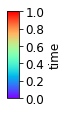

In [132]:
a = np.array([[0,1]])
plt.figure(figsize=(0.2,2))
img = plt.imshow(a, cmap="rainbow")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cb = plt.colorbar(orientation="vertical", cax=cax)
cb.set_ticks(np.arange(0,1.21,0.2))
plt.savefig("colorbar.pdf")
plt.ylabel('time')
plt.savefig('toyfig1.pdf')

Text(0, 0.5, 'Ca trace')

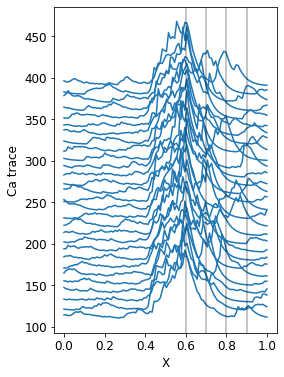

In [133]:
# simulate ca measurements
X = np.repeat(t.reshape(-1,1),Ntrials,axis=-1).T.reshape(-1)
y_ca = np.zeros_like(y).astype("float")
for i in range(2):
    y_ca[i] = np.convolve(y[i],discrete_filter,mode='full')[:-size_points]
plt.figure(figsize=(4,6))
for i in range(11,40):
    plt.plot(X[i*Nsamp:(i+1)*Nsamp],y_ca[0,i*Nsamp:(i+1)*Nsamp]+10*i,color='C0')
for i in [0.6,0.7,0.8,0.9]:
    plt.axvline(i,color='k',alpha=0.3)
plt.xlabel('X')
plt.ylabel('Ca trace')

In [134]:

y_cond = np.zeros_like(y_ca).astype("float")
y_uncd = np.zeros_like(y_ca).astype("float")
def normalize(Y_all):
    return (Y_all - Y_all.min(axis=0))/(Y_all.max(axis=0)-Y_all.min(axis=0))*0.998+0.001

for i in range(2):
    a = normalize(mg.fast_signal2uniform(y_ca[i],X,old=True))
    y_cond[i] = normalize((np.argsort(a.flatten()).argsort()/a.size)\
                .reshape(a.shape))
    y_uncd[i] = normalize((np.argsort(y_ca[i].flatten()).argsort()/y_ca[i].size)\
                .reshape(y_ca[i].shape))

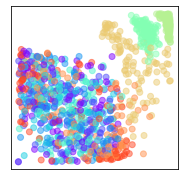

In [135]:
plt.figure(figsize=(3,3))
plt.scatter(*y_uncd[:,::10],color=cm.rainbow(X[::10]),alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.savefig('toyfig4.pdf')

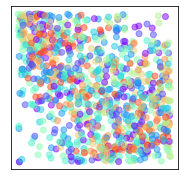

In [136]:
plt.figure(figsize=(3,3))
plt.scatter(*y_cond[:,::10],color=cm.rainbow(X[::10]),alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.savefig('toyfig5.pdf')

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/seaborn/distributions.py:690: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


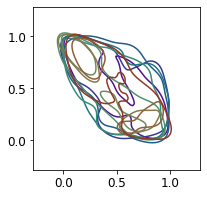

In [137]:
import seaborn as sns
plt.figure(figsize=(3,3))
for i in range(10):
    mask = (X>=0.1*i) & (X<0.1*(i+1))
    sns.kdeplot(y_cond.T[mask],color=cm.rainbow(i/10),n_levels=1)

In [138]:
import torch
import select_copula

device='cuda:0'
train_x = torch.tensor(X[Nsamp:]).float().to(device=device)
train_y = torch.tensor(y_cond.T[Nsamp:]).float().to(device=device)

# (store, waic) = select_copula.select_light(X,y_cond.T,device,'cond','/home/nina/CopulaGP/results/',
#                                            0,1,train_x=train_x,train_y=train_y)
# store.name_string

In [139]:
import bvcopula

likelihoods = [#bvcopula.GaussianCopula_Likelihood(),
               bvcopula.ClaytonCopula_Likelihood(rotation='90°')]
%time (waic_new, model_new) = bvcopula.infer(likelihoods,train_x,train_y,device=device, prior_rbf_length=2.0)

CPU times: user 25.8 s, sys: 1.89 ms, total: 25.8 s
Wall time: 25.8 s


In [140]:
interval_ends = np.array([0,0.4,0.6,0.9,1])
R = []
N, M = 20, 100
mesh = torch.stack(torch.meshgrid([torch.linspace(0.,1.,M+2)[1:-1], 
                                   torch.linspace(0.,1.,N+2)[1:-1]]),axis=-1).reshape(-1,2).to(device)
model = model_new.gp_model
for i in range(len(interval_ends)-1):
    mask = (X>interval_ends[i]) & (X<interval_ends[i+1])
    S = y_cond.T[mask]
    u_cdf = np.cumsum(np.histogram2d(*S.T,bins=[M+1,N])[0],axis=0)
    ecdf = u_cdf[:-1] / u_cdf.max(axis=0)
    # plt.imshow(ecdf)
    mean = X[mask].mean()
    test_x = (torch.ones(M*N)*mean).float().cuda(device=device)
    with torch.no_grad():
        f = model(test_x).mean
        copula = model_new.likelihood.get_copula(f)
    ccdf = copula.ccdf(mesh).detach().cpu().numpy().reshape(M,N)
    # plt.imshow(ccdf)
    # base = np.repeat((np.linspace(0,1,N+2)[1:-1]).reshape(-1,1),N,axis=1)
    var_exp = 1 - ((ecdf-ccdf)**2).sum(axis=0)/((ecdf-0.5)**2).sum(axis=0)
    R.append(var_exp.mean())
R

[0.9798374993994381,
 0.9544456264708996,
 0.9590978014766695,
 0.9136547668932937]

In [141]:
from gpytorch.settings import num_likelihood_samples

def _generate_test_samples(model, test_x: torch.Tensor) -> torch.Tensor:
    
    with torch.no_grad():
        output = model.gp_model(test_x)

    #generate some samples
    model.gp_model.eval()
    with torch.no_grad(), num_likelihood_samples(1):
        test_y = model.likelihood.get_copula(output.mean).rsample()
        Y_sim = test_y.cpu().detach().numpy()

    return Y_sim

testX = np.linspace(0,1,X.shape[0])
test_x = torch.tensor(testX).float().to(device=device)

Y_sim = _generate_test_samples(model_new, test_x)

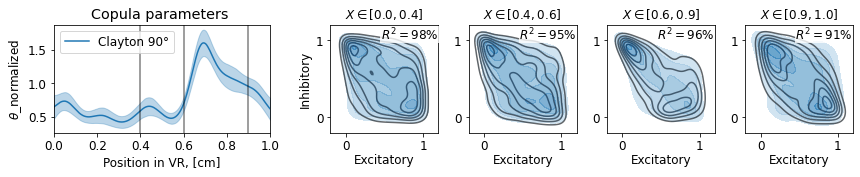

In [148]:
from utils import Plot_Copula_Density, Plot_MixModel_Param_MCMC

fig = plt.figure(figsize=(12,1.5))
nul_axis = fig.add_axes([0.1,  0,0.25,1])
plt.close(fig)

fig = plt.figure(figsize=(12,1.5))
# axA = fig.add_axes([0,0,1,1])
ax0 = fig.add_axes([0.075,  0,0.25,1])
ax = np.array(
    [fig.add_axes([0.395, 0,0.125,1]),
      fig.add_axes([0.555,0,0.125,1]),
      fig.add_axes([0.715,0,0.125,1]),
      fig.add_axes([0.875,0,0.125,1])])

Plot_MixModel_Param_MCMC([ax0,nul_axis],model_new,
        test_x,testX,#rho=_get_pearson(X,Y),
        title=f'', normalized_thetas=False)

for b in interval_ends[1:-1]:
    ax0.axvline(b, color='black', alpha=0.5)

Plot_Copula_Density(ax, testX.squeeze(), Y_sim.squeeze(), 
                              interval_ends, shade=True)
Plot_Copula_Density(ax, X.squeeze(), y_cond.T.squeeze(), 
                              interval_ends, shade=False, color='#073763ff')
titles = [r"$X\in[{},{}]$".format(s,e) for s,e in zip(interval_ends[:-1],interval_ends[1:])]
for i in range(4):
    ax[i].set_title(titles[i],fontsize=12)
    ax[i].set_xlabel('Excitatory',labelpad=1,fontsize=12)
    ax[i].text(0.45,1.0,f'$R^2={R[i]*100:.0f}\%$', fontsize=12,
                    bbox={'facecolor':'white', 'edgecolor':'none', 'alpha':0.8, 'pad':0.3})
    ax[i].set_yticks([0,1],minor=False)
    ax[i].set_yticklabels([0,1])
    ax[i].set_xticks([0,1],minor=False)
    ax[i].set_xticklabels([0,1])
ax[0].set_ylabel('Inhibitory')
    
fig.savefig('toyfig6.pdf')

In [449]:
Plot_MixModel_Param_MCMC(top_axes,model,
        test_x,testX*xscale,#rho=_get_pearson(X,Y),
        title=f' for {name_x} vs {name_y}')

[99.0, 98.0, 97.0, 96.0]

In [982]:
plt.figure(figsize=(4,2))
# plt.plot(x,level,label='Shared noise level',color='C2')

test_x=torch.tensor(x,device=device).float()
with torch.no_grad():                            
    output = model_new.gp_model(test_x)
thetas, mixes = model_new.gplink(output.rsample(torch.Size([10])), normalized_thetas=False)

for i in [0.6,0.7,0.8,0.9]:
    plt.axvline(i,color='k',alpha=0.3)

th = (thetas[0]+0.5)*2
mean = th.mean(0).cpu().numpy()
std = th.std(0).cpu().numpy()
plt.plot(x,mean,label='Copula parameter',color='C0')
plt.fill_between(x,mean-std,mean+std,color='C0',alpha=0.2)
# plt.ylim([-1,2.6])
# plt.legend(ncol=2,loc=(-0.1,1.05))
plt.scatter(x,np.zeros_like(x),color=cm.rainbow(x))
plt.ylabel('Copula Parameter')
plt.xlabel('X')
plt.yticks([])
plt.savefig('toyfig_new2H.pdf')

NameError: name 'model_new' is not defined

<Figure size 288x144 with 0 Axes>

#### 

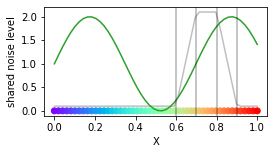

In [369]:
plt.figure(figsize=(4,2))
plt.plot(x,fr,color='grey',alpha=0.5)
plt.plot(x,level,color='C2')
plt.scatter(x,np.zeros_like(x),color=cm.rainbow(x))
for i in [0.6,0.7,0.8,0.9]:
    plt.axvline(i,color='k',alpha=0.3)

plt.xlabel('X')
plt.ylabel('shared noise level')
plt.savefig('toyfig_new2A.pdf')

In [250]:
waics, models = store.model_init(device).ablate(train_x,train_y)
(waic,waics)

(-0.09401334077119827,
 [-0.09300865232944489, -0.076846644282341, -0.0893765389919281])

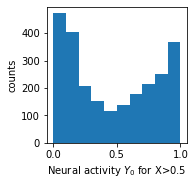

In [352]:
plt.figure(figsize=(2.5,2.5))
plt.hist(y_uncd[0][X>0.5])
plt.xlabel(r"Neural activity $Y_0$ for X>0.5")
plt.ylabel('counts')
plt.savefig('toyfig8.pdf')